**Podczas zajęć omawialiśmy 3 główne rodzaje sieci:**
- sieci neuronowe zwykłe,
- konwolucyjne sieci neuronowe (głównie do obrazów),
- rekurencyjne sieci neuronowe wraz z modyfikacjami (głównie do NLP).

**Do każdego z 3 tematów zostało przygotowane jedno zadanie do zrobienia. Powodzenia!**

<br>

_Pamiętaj, nie musisz robić tych zadań w całości/wszystkich. Jeśli wybierasz jedno - wybierz to, z którego tematu umiesz najmniej, a chcesz coś umieć. Możesz je wykorzystać jako praktykę przed rozmową rekrutacyjną do pracy z sieciami neuronowymi._

# Case study 1: Sieci neuronowe

**Zoptymalizuj i oceń sieć neuronową na danych `digits`. Wybierz parametry do testowania. Skorzystaj ze znanych sobie dobrych praktyk.**

1. Wykorzystaj bibliotekę `sklearn` i zrób `GridSearch` parametrów z `CrossValidation` (np. `cv=5`).
2. Wykorzystaj bibliotekę `tensorflow` i korzystaj z **regularyzacji**, **dropoutów**, ... - przyrostowo badaj sieci. 

_Pamiętaj o skalowaniu danych i `EarlyStopping` jako metodzie na określenie liczby epok._

<br>

**_Jakaś estymacja czasowa kompletnie niewiążąca:_**
1. 2h z ponownym przejrzeniem materiałów (notebook 2.) i poszukaniem jak robić `GridSearch` z `CV`
2. 2h z ponownym przejrzeniem materiałów (notebook 3.)

In [61]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X, y = digits.data, digits.target

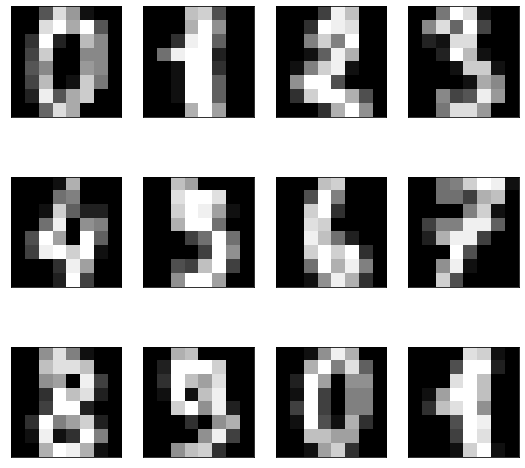

In [62]:
import matplotlib.pyplot as plt

n_col = 4
n_row = 3

plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

for i in range(n_row * n_col):
    
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
    
plt.show()

In [63]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))

y.shape

(1797, 10)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300, random_state=123)

## Scikit-learn

In [87]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [69]:
model = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=[10], max_iter=1000, random_state=123))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.93

In [92]:
for number in [10, 50, 100, 200, 300]:
    
    model = make_pipeline(StandardScaler(),
                          MLPClassifier(hidden_layer_sizes=[number],
                                        learning_rate_init=0.1,
                                        activation='logistic',
                                        max_iter=10_000,
                                        validation_fraction=0.2,
                                        early_stopping=True,
                                        n_iter_no_change=5,
                                        random_state=123)
                         )
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f"number: {number}, accuracy: {accuracy_score(y_test, y_pred)}")

number: 10, accuracy: 0.86
number: 50, accuracy: 0.9333333333333333
number: 100, accuracy: 0.95
number: 200, accuracy: 0.9266666666666666
number: 300, accuracy: 0.9266666666666666


In [89]:
pipe = Pipeline([("scaler", MinMaxScaler()),
                 ("classifier", MLPClassifier(max_iter=10_000,
                                              early_stopping=True,
                                              n_iter_no_change=5,
                                              random_state=123))
                ])

param_grid = {"classifier__learning_rate_init": [1e-4, 0.001, 0.01, 0.1],
              "classifier__hidden_layer_sizes": [10, 50, 100, 200, 300],
              "classifier__activation": ['identity', 'logistic', 'tanh', 'relu']}

gs = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

y_pred = gs.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, y_pred)}')

{'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': 100, 'classifier__learning_rate_init': 0.1}
accuracy: 0.9366666666666666


## Tensorflow (Keras)

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
tf.keras.utils.set_random_seed(123)

In [95]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [109]:
n_classes = 10
model = Sequential()

model.add(Dense(50,
                activation="relu",
                kernel_regularizer=l2(0.01),
                bias_regularizer=l2(0.01),
                input_shape=(X_train.shape[1], ))
         )

model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 50)                3250      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                510       
                                                                 
Total params: 3,760
Trainable params: 3,760
Non-trainable params: 0
_________________________________________________________________


In [110]:
early_stopping = EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)

model.fit(X_train, y_train, 
          batch_size=16, 
          validation_split=0.2, 
          callbacks=[early_stopping], 
          epochs=100
         )

accuracy_score(y_test, np.round(model.predict(X_test)))

Epoch 1/100
75/75 [==============================] - 1s 4ms/step - loss: 2.2883 - categorical_accuracy: 0.4369 - val_loss: 1.6258 - val_categorical_accuracy: 0.7567
Epoch 2/100
75/75 [==============================] - 0s 2ms/step - loss: 1.4039 - categorical_accuracy: 0.7761 - val_loss: 1.1375 - val_categorical_accuracy: 0.8600
Epoch 3/100
75/75 [==============================] - 0s 2ms/step - loss: 1.0557 - categorical_accuracy: 0.8622 - val_loss: 0.9034 - val_categorical_accuracy: 0.9133
Epoch 4/100
75/75 [==============================] - 0s 2ms/step - loss: 0.8821 - categorical_accuracy: 0.9023 - val_loss: 0.7661 - val_categorical_accuracy: 0.9333
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 0.7586 - categorical_accuracy: 0.9206 - val_loss: 0.6735 - val_categorical_accuracy: 0.9600
Epoch 6/100
75/75 [==============================] - 0s 2ms/step - loss: 0.6654 - categorical_accuracy: 0.9357 - val_loss: 0.6078 - val_categorical_accuracy: 0.9600
Epoch 7/10

0.97

# Case study 2: Konwolucyjne sieci neuronowe

**Weź udział w konkursie na Kagglu: https://www.kaggle.com/competitions/cifar-10/overview**

> 1. Zapoznaj się z danymi (rozmiary, wygląd, itp.) i przygotuj je

In [28]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

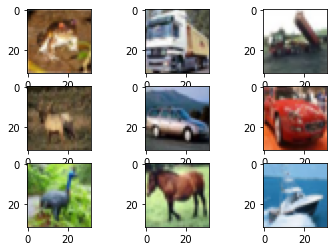

In [30]:
import matplotlib.pyplot as plt

for i in range(9):
    
    plt.subplot(330 + 1 + i)  # siatka 3 x 3, a potem pozycja obrazka
    plt.imshow(X_train[i])
    
plt.show()  

In [31]:
X_train = X_train / 255
X_test = X_test / 255

In [32]:
np.unique(y_train).shape

(10,)

In [33]:
y_train[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

In [34]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [35]:
y_train[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

> 2. Zaimplementuj i sprawdź zwykłe sieci konwolucyjne (notebooki 4, 5)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D

np.random.seed(123)

In [38]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=X_train[0].shape, padding="same"))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                327690    
                                                                 
Total params: 330,122
Trainable params: 330,122
Non-trainable params: 0
_________________________________________________________________


In [41]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping], batch_size=32)

Epoch 1/100
   4/1250 [..............................] - ETA: 24s - loss: 0.9582 - categorical_accuracy: 0.6719

2023-09-08 20:11:35.435464: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.


1250/1250 [==============================] - 19s 15ms/step - loss: 1.0337 - categorical_accuracy: 0.6432 - val_loss: 1.2697 - val_categorical_accuracy: 0.5688
Epoch 2/100
1250/1250 [==============================] - 20s 16ms/step - loss: 0.9470 - categorical_accuracy: 0.6717 - val_loss: 1.2379 - val_categorical_accuracy: 0.5845
Epoch 3/100
1250/1250 [==============================] - 21s 17ms/step - loss: 0.8626 - categorical_accuracy: 0.6997 - val_loss: 1.2878 - val_categorical_accuracy: 0.5895
Epoch 4/100
1250/1250 [==============================] - 20s 16ms/step - loss: 0.7881 - categorical_accuracy: 0.7265 - val_loss: 1.2756 - val_categorical_accuracy: 0.5854
Epoch 5/100
1250/1250 [==============================] - 22s 17ms/step - loss: 0.7159 - categorical_accuracy: 0.7534 - val_loss: 1.3307 - val_categorical_accuracy: 0.5894
Epoch 6/100
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6478 - categorical_accuracy: 0.7757 - val_loss: 1.3780 - val_categorical_acc

In [42]:
model.evaluate(X_test, y_test, verbose=0)

[1.2403626441955566, 0.5800999999046326]

> 3. *Poszukaj optymalnych parametrów (liczba warstw, bloki konwolucyjne, warstwy `Dense`, filtry - rozmiar i liczba, paddingi, dropouty, itp.)

In [45]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=5, activation='sigmoid', input_shape=X_train[0].shape, padding="same"))
model.add(AveragePooling2D(pool_size=2, strides=2))  # UWAGA: 'avg_pooling' z parametrem 'strides=2'

model.add(Conv2D(filters=16, kernel_size=5, activation='sigmoid'))  # UWAGA: brak 'paddingu'
model.add(AveragePooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(84, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_2 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 576)               0         
                                                                 
 dense_5 (Dense)             (None, 128)              

In [46]:
model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping], batch_size=32)

model.evaluate(X_test, y_test, verbose=0)

Epoch 1/100


2023-09-08 20:34:50.083549: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.


1250/1250 [==============================] - 14s 10ms/step - loss: 2.0823 - categorical_accuracy: 0.2206 - val_loss: 1.9692 - val_categorical_accuracy: 0.2780
Epoch 2/100
1250/1250 [==============================] - 12s 10ms/step - loss: 1.8750 - categorical_accuracy: 0.3043 - val_loss: 1.8183 - val_categorical_accuracy: 0.3373
Epoch 3/100
1250/1250 [==============================] - 12s 10ms/step - loss: 1.7172 - categorical_accuracy: 0.3735 - val_loss: 1.6567 - val_categorical_accuracy: 0.3979
Epoch 4/100
1250/1250 [==============================] - 12s 10ms/step - loss: 1.6187 - categorical_accuracy: 0.4094 - val_loss: 1.5960 - val_categorical_accuracy: 0.4217
Epoch 5/100
1250/1250 [==============================] - 12s 10ms/step - loss: 1.5489 - categorical_accuracy: 0.4365 - val_loss: 1.5479 - val_categorical_accuracy: 0.4504
Epoch 6/100
1250/1250 [==============================] - 13s 10ms/step - loss: 1.4868 - categorical_accuracy: 0.4622 - val_loss: 1.4865 - val_categorical_acc

[1.2161840200424194, 0.5656999945640564]

> 4. Wykorzystaj transfer learning, np. z `VGG19`, `EfficientNetV2`, `ResNext` (notebook 6)

In [ ]:
# TODO

In [48]:
from tensorflow.keras.applications.vgg19 import VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [50]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))  # pierwszym parametrem 'output_shape' jest 'None'
top_model.add(Dense(128, activation='tanh'))
top_model.add(Dropout(0.5))
top_model.add(Dense(10, activation='softmax'))

top_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 66,954
Trainable params: 66,954
Non-trainable params: 0
_________________________________________________________________


In [51]:
model = Sequential()
model.add(base_model)
model.add(top_model)

base_model.trainable = False  # wagi bazowego modelu nie będą się zmieniać
model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 sequential_5 (Sequential)   (None, 10)                66954     
                                                                 
Total params: 20,091,338
Trainable params: 66,954
Non-trainable params: 20,024,384
_________________________________________________________________


In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping], batch_size=32)
model.evaluate(X_test, y_test, verbose=0)

Epoch 1/100


2023-09-08 20:46:00.730527: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.


1250/1250 [==============================] - 148s 118ms/step - loss: 1.5431 - accuracy: 0.4550 - val_loss: 1.3215 - val_accuracy: 0.5283
Epoch 2/100
1250/1250 [==============================] - 156s 125ms/step - loss: 1.3647 - accuracy: 0.5207 - val_loss: 1.2632 - val_accuracy: 0.5538
Epoch 3/100
1250/1250 [==============================] - 162s 130ms/step - loss: 1.3235 - accuracy: 0.5365 - val_loss: 1.2481 - val_accuracy: 0.5594
Epoch 4/100
1250/1250 [==============================] - 177s 141ms/step - loss: 1.2949 - accuracy: 0.5478 - val_loss: 1.2557 - val_accuracy: 0.5569
Epoch 5/100
1250/1250 [==============================] - 158s 126ms/step - loss: 1.2829 - accuracy: 0.5526 - val_loss: 1.2196 - val_accuracy: 0.5717
Epoch 6/100
1250/1250 [==============================] - 154s 123ms/step - loss: 1.2694 - accuracy: 0.5567 - val_loss: 1.2485 - val_accuracy: 0.5631
Epoch 7/100
1250/1250 [==============================] - 159s 127ms/step - loss: 1.2588 - accuracy: 0.5598 - val_loss:

[1.205295205116272, 0.5771999955177307]

> 5. Wykorzystaj augmentację danych przy najlepszej dotychczasowej sieci (notebook 6)

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.2,
                horizontal_flip=True,
    )

In [55]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                            steps_per_epoch=X_train.shape[0] // 32,
                            epochs=100,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping])

Epoch 1/100


/tmp/ipykernel_206/3875422917.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),


1562/1562 [==============================] - 184s 118ms/step - loss: 1.4727 - accuracy: 0.4827 - val_loss: 1.2497 - val_accuracy: 0.5617
Epoch 2/100
1562/1562 [==============================] - 187s 120ms/step - loss: 1.4542 - accuracy: 0.4915 - val_loss: 1.2800 - val_accuracy: 0.5504
Epoch 3/100
1562/1562 [==============================] - 190s 122ms/step - loss: 1.4499 - accuracy: 0.4918 - val_loss: 1.2589 - val_accuracy: 0.5617
Epoch 4/100
1562/1562 [==============================] - 189s 121ms/step - loss: 1.4421 - accuracy: 0.4957 - val_loss: 1.2738 - val_accuracy: 0.5569
Epoch 5/100
1562/1562 [==============================] - 189s 121ms/step - loss: 1.4387 - accuracy: 0.4960 - val_loss: 1.2632 - val_accuracy: 0.5590
Epoch 6/100
1562/1562 [==============================] - 189s 121ms/step - loss: 1.4358 - accuracy: 0.4971 - val_loss: 1.2831 - val_accuracy: 0.5537


### Modele `emsemble`

> 6. Sprawdź, czy model `ensemble` ([ARTYKUŁ](https://machinelearningmastery.com/ensemble-methods-for-deep-learning-neural-networks/)) będzie działał lepiej.

**modele** `average ensemble`: https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/  

**UWAGA:**: _Analizę przeprowadziłem dla innego (mniejszego) zbioru danych, żeby obliczenia były szybsze (wnioski powinny być analogiczne)._

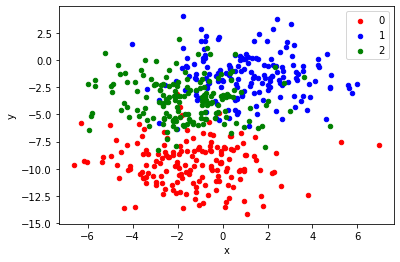

In [58]:
# scatter plot of blobs dataset

from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:, 0], y=X[:, 1], label=y))
grouped = df.groupby('label')

colors = {0: 'red', 1: 'blue', 2: 'green'}
fig, ax = pyplot.subplots()

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

pyplot.show()

Train: 0.840, Test: 0.757


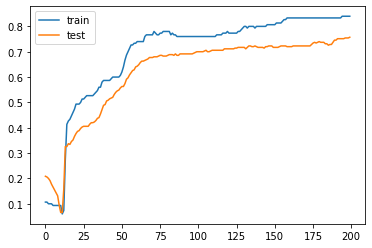

In [59]:
# fit high variance mlp on blobs classification problem

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(15, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# learning curves of model accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

> 0.723
> 0.760
> 0.786
> 0.766
> 0.777
> 0.749
> 0.754
> 0.780
> 0.729
> 0.766
> 0.769
> 0.754
> 0.783
> 0.783
> 0.794
> 0.760
> 0.769
> 0.757
> 0.760
> 0.766
> 0.746
> 0.774
> 0.797
> 0.726
> 0.783
> 0.751
> 0.763
> 0.743
> 0.754
> 0.780
Scores Mean: 0.763, Standard Deviation: 0.019


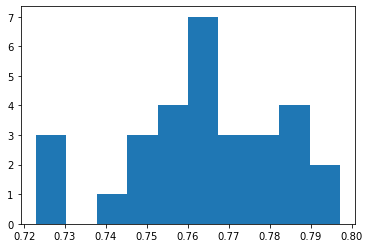

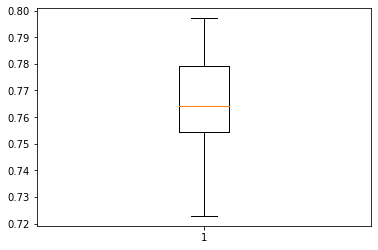

In [61]:
# demonstrate high variance of mlp model on blobs classification problem
import numpy as np

# fit and evaluate a neural net model on the dataset
def evaluate_model(trainX, trainy, testX, testy):
    
    # define model
    model = Sequential()
    model.add(Dense(15, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
     
    # fit model
    model.fit(trainX, trainy, epochs=200, verbose=0)
    
    # evaluate the model
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    
    return test_acc
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# repeated evaluation
n_repeats = 30

scores = list()
for _ in range(n_repeats):
    
    score = evaluate_model(trainX, trainy, testX, testy)
    print('> %.3f' % score)
    scores.append(score)

# summarize the distribution of scores
print('Scores Mean: %.3f, Standard Deviation: %.3f' % (np.mean(scores), np.std(scores)))

# histogram of distribution
pyplot.hist(scores, bins=10)
pyplot.show()

# boxplot of distribution
pyplot.boxplot(scores)
pyplot.show()

In [68]:
# model averaging ensemble and a study of ensemble size on test accuracy

from sklearn.metrics import accuracy_score
 
# fit model on dataset
def fit_model(trainX, trainy):
    
    # define model
    model = Sequential()
    model.add(Dense(15, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
    # fit model
    model.fit(trainX, trainy, epochs=200, verbose=0)
    
    return model
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = np.array(yhats)

    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
 
    # argmax across classes
    result = np.argmax(summed, axis=1)
 
    return result
 
# evaluate ensemble model
def evaluate_members(members, testX, testy):
    
    # make prediction
    yhat = ensemble_predictions(members, testX)
 
    # calculate accuracy
    return accuracy_score(testy, yhat)

In [70]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

trainy = to_categorical(trainy)

# repeated evaluation
n_repeats = 30
n_members = 5

scores = list()
for _ in range(n_repeats):
    
    # fit all models
    members = [fit_model(trainX, trainy) for _ in range(n_members)]
    
    # evaluate ensemble
    score = evaluate_members(members, testX, testy)
    print('> %.3f' % score)
    scores.append(score)

# summarize the distribution of scores
print('Scores Mean: %.3f, Standard Deviation: %.3f' % (np.mean(scores), np.std(scores)))

11/11 [==============================] - 0s 1ms/step
> 0.777
11/11 [==============================] - 0s 2ms/step
> 0.774
11/11 [==============================] - 0s 1ms/step
> 0.769
11/11 [==============================] - 0s 2ms/step
> 0.754
11/11 [==============================] - 0s 1ms/step
> 0.769
11/11 [==============================] - 0s 1ms/step
> 0.757
11/11 [==============================] - 0s 1ms/step
> 0.771
11/11 [==============================] - 0s 1ms/step
> 0.769
11/11 [==============================] - 0s 1ms/step
> 0.766
11/11 [==============================] - 0s 1ms/step
> 0.760
11/11 [==============================] - 0s 1ms/step
> 0.766
11/11 [==============================] - 0s 1ms/step
> 0.760
11/11 [==============================] - 0s 1ms/step
> 0.763
11/11 [==============================] - 0s 2ms/step
> 0.771
11/11 [==============================] - 0s 1ms/step
> 0.769
11/11 [==============================] - 0s 1ms/step
> 0.777
11/11 [=================

# Case study 3: Rekurencyjne sieci neuronowe

W notebooku na _**Kaggle**_ jest pokazane jak można korzystać z gotowych **Embeddingów**. Pod koniec zajęć zacząłem pokazywać na żywym organizmie wykorzystywanie takich kagglowych notebooków. Warto zwrócić uwagę na natępujące rzeczy:

1. **W pracy Data Science warto wykorzystywać gotowce** - to co ktoś zrobił: _poradniki_, _artykuły_, _**Kaggle**_
2. **Warto testować coś najmniejszym kosztem**: zdecydowałem się na upload małych ilości danych do _**Kaggla**_ zamiast download dużych **Embeddingów** + nie musiałem wyszukiwać kawałków kodu do skopiowania; jednak podejście ze ściągnięciem embeddingów mogłoby być też efektywnym podejściem
3. **Po takim wstępnym wykorzystaniu czyjegoś kodu warto go dobrze przetestować.** Na zajęciach nie zdążyłem dojść do tego kroku, ale ostatecznie na różny sposób sprawdziłem, czy embeddingi wczytałem i zintegrowałem dobrze. Ślady tego sprawdzania są w noteboku.
4. **Takie działania zawsze zajmują czas, a my często go nie doszacowujemy.** Myślałem, że w pół godziny uda mi się pokazać takie zintegrowanie. Ostatecznie trwało to nawet około 1.5h, bo skończyłem około 18:00 bez porządkowania kodu.

### *Zadanie dodatkowe:
Nie czytając notebooka _"o wykorzystaniu Embeddingów"_ (https://www.kaggle.com/code/makowtoms/lstm-using-pretrained-embeddings) wykorzystaj notebook _"oryginalny"_ (https://www.kaggle.com/code/neeraj17/lstm-using-pretrained-embeddings), by wytrenować sieć na **pretrained Embedingach** z Facebooka. 

<details>
<summary>Wskazówki - kliknij, by zobaczyć</summary>

- Zapoznaj się z dokumentacją: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/get_word_index

- Możesz skorzystać z kodu bezpośrednio w dokumentacji i użyć `inverted_word_index` (odwrócona kolejność `(id, word)`) zamiast `word_index`.
    
</details>


### Zadanie

**Na danych `imdb` (i/lub danych z załączonego notebooka `movie-review-sentiment-analysis-kernels-only`) przestestować:**

1. Embeddingi tworzone w locie **_vs_** Gotowe embeddingi z notebooka https://www.kaggle.com/code/makowtoms/lstm-using-pretrained-embeddings

**Następnie przetestować poniższe sieci:**

2. `SimpleRNN`
3. `LSTM` - porównaj na zbiorze testowym jakość działania modelu wziętego z najlepszej iteracji oraz modelu po zatrzymaniu uczenia
4. `LSTM` + warstwa dense na końcu
5. `Bidirectional LSTM`
6. `Dwuwarstwowy LSTM`
7. `CNN + LSTM` - przepuścić dane przez warstwę konwolucyjną (`Conv1D`) + `MaxPooling`, a następnie dołożyć `LSTM`

In [15]:
# TODO